# Import all the packages.

In [1]:
import DifferentialEquations
import DynamicalSystems
import Statistics
import Plots

In [2]:
using DynamicalSystems
using DifferentialEquations
using Statistics
using Plots

# The function of two coupled SQUIDs driven by a sinusoidal field.

$$\begin{align}
    \ddot{\phi_{1}} + g \dot{\phi_{1}} + v \sin (2 \pi \phi_{1})  + \frac{1}{1-e^{2}} \phi_{1} - \frac{e}{1-e^{2}} \phi_{2} = \frac{1}{1+e} \phi_{ext}\\
    \ddot{\phi_{2}} + g \dot{\phi_{2}} + v \sin (2 \pi \phi_{2})  + \frac{1}{1-e^{2}} \phi_{2} - \frac{e}{1-e^{2}} \phi_{1} = \frac{1}{1+e} \phi_{ext}
\end{align}$$

with:

$$ \phi_{ext} = fdc + fac  \cos (\Omega t) $$

In [4]:
@inline @inbounds function squid(u, p, t)
   g, v, fac, fdc, e, om = p # Here om = $ \Omega $
   x1, x2, y1, y2, z = u
   du1 = y1
   du2 = y2
   du3 = -g*y1 -(x1/(1-e*e)) -v*sin(2*pi*x1) + ((1-e)/(1-e*e))*(fac*cos(z) + fdc) +((e*x2)/(1-e*e))
   du4 = -g*y2 -(x2/(1-e*e)) -v*sin(2*pi*x2) + ((1-e)/(1-e*e))*(fac*cos(z) + fdc) +((e*x1)/(1-e*e))
   du5 = om
   return SVector{5}(du1, du2, du3, du4, du5)
end

squid (generic function with 1 method)

# The relative jacobian. 

In [5]:
@inline @inbounds function loop_jac(u, p, t)
    g, v, fac, fdc, e, om = p
    x1 = u[1]; x2 = u[2]; y1 = u[3]; y2 = u[4]; z = u[5]
    J = @SMatrix [0  0  1  0  0;
    0  0  0  1  0;
    -(1/(1-e*e))-v*2*pi*cos(2*pi*x1)  e/(1-e*e)  -g  0  -fac*((1-e)/(1-e*e))*sin(z);
    e/(1-e*e)  -(1/(1-e*e))-v*2*pi*cos(2*pi*x2)  0  -g  -fac*((1-e)/(1-e*e))*sin(z);
    0  0  0  0  0]
    return J
end

loop_jac (generic function with 1 method)

# Parameters.

In [21]:
g, v, fac, fdc, e, om = 0.024, 0.1369, 0.02, 0.0, 0.31, 1.2
p = [g, v, fac, fdc, e, om]
u0 = [0.487, 0.126, 0.0909, 0.925, 0.280] # Initial Conditions.
ds = ContinuousDynamicalSystem(squid, u0, p, loop_jac)
tinteg =  tangent_integrator(ds, 5)

t: 0.0
u: 5×6 StaticArrays.SArray{Tuple{5,6},Float64,2,30} with indices SOneTo(5)×SOneTo(6):
 0.487   -0.477182    0.362961     0.469841   -0.507257  -0.403108
 0.126   -0.382607    0.00824216  -0.240878   -0.463069   0.762292
 0.0909  -0.774295   -0.392684    -0.0632404   0.478961  -0.113415
 0.925   -0.0851542   0.148848    -0.842948   -0.234188  -0.452976
 0.28    -0.138292    0.831766    -0.0816469   0.493973   0.19587

# The range of Omega

In [22]:
om_initial = 0.86
om_final = 0.92
period_final = 2*pi/om_initial 
period_initial = 2*pi/om_final
period_step = 0.002 # The step of bifurcation on period.

period_range = period_initial:period_step:period_final 
nr_period = 300 # The nr of periods that we run the system plus nr of periods for the transient state.
per_step = 0.01 # The proportion of period that we want as an output.

0.01

In [23]:
omega = zeros(length(period_range))
lyap = zeros(length(period_range), 5)

239×5 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 ⋮                   
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0

# The main program.

In [52]:
for (i, period) in enumerate(period_range)
   
   # Parameters.
   om = (2*pi)/period
   set_parameter!(ds,6,om)
   global u0, nr_period, per_step
   
   # Runing the system.
   data = trajectory(ds, nr_period*period, dt=period*per_step, u0, Ttr = nr_period*period)
   
   # Calculating the Lyapunovs.
   reinit!(tinteg, u0, orthonormal(5, 5))
   lyap[i,:] = lyapunovs(tinteg, nr_period*period, period, nr_period*period)
   
   # Omega. 
   omega[i]=om
   
   # We have to put some noise because the system is multistable.
   s = 0.0001*rand(4) 
   u0 = [data[end,1]+s[1],data[end,2]+s[2],data[end,3]+s[3],data[end,4]+s[4],0]

   # println(i) # If you want to print the steps.
    
 end

# Plots

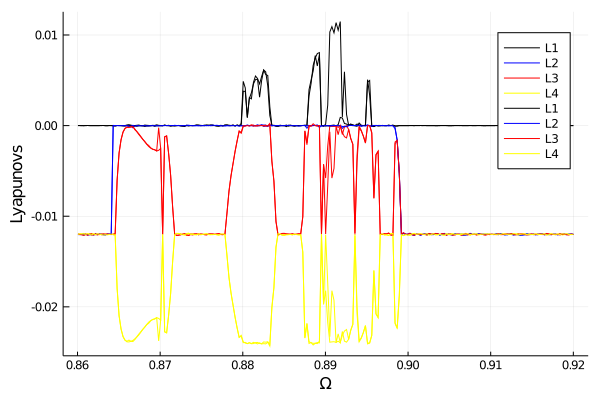

In [53]:
# All the four Lyapunov's. The fifth is always zero.

plot!(omega, lyap[:,1], markersize=1.0, color = "black", xlabel="Ω", ylabel="Lyapunovs", label = "L1")
plot!(omega, lyap[:,2], markersize=1.0, color = "blue", xlabel="Ω", ylabel="Lyapunovs", label = "L2")
plot!(omega, lyap[:,3], markersize=1.0, color = "red", xlabel="Ω", ylabel="Lyapunovs", label = "L3")
plot!(omega, lyap[:,4], markersize=1.0, color = "yellow", xlabel="Ω", ylabel="Lyapunovs", label = "L4")



# savefig("Fig_01.png") if you want to save the fig.

If you have any questions, please feel free to sent me an email on jonialdshena@gmail.com. 
If I have helped you in research that led to a publication, please be kind enough to cite it, using my Git-Hub acount.